# INF200 Lecture No 13

###  6 December 2021

## Today's topics

1. A little more on numerical performance
    1. An interesting observation
    1. Systematic analysis
1. Scientific computing: Chutes & Ladders — Markov analysis
1. The block project
    1. Practical information
    1. Project preview

----------------

# A little more on numerical performance

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

print(f'NumPy      {np.__version__}')
print(f'Pandas     {pd.__version__}')
print(f'Matplotlib {matplotlib.__version__}')

NumPy      1.21.2
Pandas     1.3.4
Matplotlib 3.5.0


## An interesting observation

1. Create a square random matrix
1. Perform a mathematical operation on 
    1. a single column
    1. a single row
1. Compare times

In [9]:
mc = np.random.random((10000, 10000))

In [24]:
%timeit mc[:, 5] * 0.5

90.8 µs ± 935 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%timeit mc[5, :] * 0.5

3.35 µs ± 32.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


- Multiplying a row is almost 30 times faster than multiplying a column
- Why?
- We can get the opposite result with a slight modification

In [26]:
mf = np.array(np.random.random((10000, 10000)), order='F')

In [27]:
%timeit mf[:, 5] * 0.5

3.32 µs ± 34.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
%timeit mf[5, :] * 0.5

90.5 µs ± 445 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


- The reason for this behavior is *memory layout* for arrays
- NumPy default:
    - C-style memory layout
    - Row elements contiguous in memory
    - Also called *row-major* ordering
- Alternative `order='F'`
    - FORTRAN-style memory layout
    - Column elements contiguous in memory
    - Also called *column-major* ordering
- Operations on contiguous memory are fast
    - Data can be moved much more efficiently to CPU

## Systematic analysis

- Above, we only looked at single array size
- To confirm results, we need to look at a range of sizes
- Focus on sizes that are powers of 2
    - Watch out for memory size: $16384\times 16384 \times 8\text{B}=2\text{GB}$

In [30]:
from timeit import Timer

In [37]:
t_c_col = [(n, *Timer(stmt='mc[:, 5] * 0.5', 
                      setup='mc = np.random.random((n, n))', 
                      globals={'np': np, 'n': n}).autorange())
            for n in [2**k for k in range(3, 15)]]

In [44]:
tcc.T / tcc.n

,0,1,2,3,4,5,6,7,8,9,10,11
n,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Loops,6.250000e+04,3.125000e+04,1.562500e+04,7.812500e+03,3.906250e+03,7.812500e+02,3.906250e+02,9.765625e+01,9.765625e+00,1.220703e+00,2.441406e-01,6.103516e-02
T_all,4.755096e-02,2.397914e-02,1.220828e-02,6.208735e-03,3.878493e-03,9.753330e-04,6.965778e-04,3.544356e-04,1.009895e-04,5.144097e-05,3.060081e-05,2.097124e-05
T,9.510192e-08,4.795828e-08,2.441657e-08,1.241747e-08,7.756987e-09,4.876665e-09,3.482889e-09,3.544356e-09,5.049475e-09,1.028819e-08,1.530040e-08,2.097124e-08


In [46]:
tcc = pd.DataFrame(t_c_col)
tcc.columns = ['n', 'Loops', 'T_all']
tcc['T_stmt'] = tcc.T_all / tcc.Loops    # time per statement execution
tcc['T_op'] = tcc.T_stmt / tcc.n * 1e9   # time per single operation, in ns
tcc.set_index('n', inplace=True)

In [47]:
tcc

,Loops,T_all,T_stmt,T_op
n,,,,
8,500000,0.380408,7.608154e-07,95.101923
16,500000,0.383666,7.673324e-07,47.958277
32,500000,0.390665,7.813301e-07,24.416567
64,500000,0.397359,7.947181e-07,12.417470
128,500000,0.496447,9.928943e-07,7.756987
256,200000,0.249685,1.248426e-06,4.876665
512,200000,0.356648,1.783239e-06,3.482889
1024,100000,0.362942,3.629420e-06,3.544356
2048,20000,0.206826,1.034132e-05,5.049475


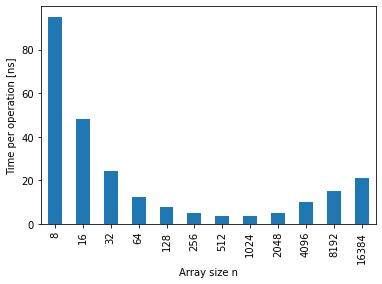

In [50]:
tcc.T_op.plot(kind='bar');
plt.xlabel('Array size n');
plt.ylabel('Time per operation [ns]');

- Looks like a "sweet spot" around matrix size $512\times 512$
- Probably dependent on how data is precisely fed in to CPU

### Create helper function to run more cases

In [54]:
def mat_op_timer(stmt, setup, sizes):
    """
    Time stmt using given setup for problem sizes given.
    
    setup must use "n" to determine size of test data.
    
    Returns dataframe with results.
    """
    
    res = pd.DataFrame(((n, *Timer(stmt=stmt, setup=setup,
                                  globals={'np': np, 'n': n}).autorange())
                        for n in sizes),
                        columns=['n', 'Loops', 'T_all'])
    res['T_stmt'] = res.T_all / res.Loops    # time per statement execution
    res['T_op'] = res.T_stmt / res.n * 1e9   # time per single operation, in ns
    res.set_index('n', inplace=True)
    return res

### Collect column-wise data

In [83]:
sz = [2**k for k in range(3, 16)]
tcc = mat_op_timer('mc[:, 1] * 0.5', 'mc = np.random.random((n, n))', sz)

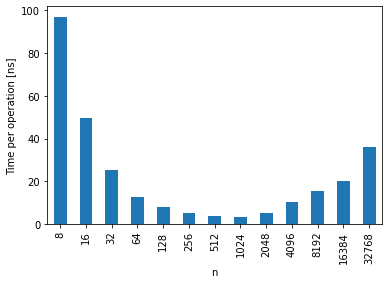

In [84]:
tcc.T_op.plot(kind='bar');
plt.ylabel('Time per operation [ns]');

- Consistent with result above

### Collect row-wise data

In [85]:
tcr = mat_op_timer('mc[1, :] * 0.5', 'mc = np.random.random((n, n))', sz)

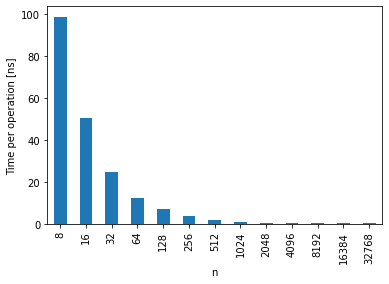

In [86]:
tcr.T_op.plot(kind='bar');
plt.ylabel('Time per operation [ns]');

- Becomes extremely fast for large sizes
- Plot logarithmically 

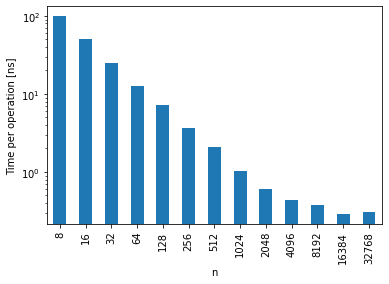

In [87]:
tcr.T_op.plot(kind='bar', logy=True);
plt.ylabel('Time per operation [ns]');

### Combine data for column- and row-wise operations

- Pandas `merge()` allows us to combine data from two DataFrames
    - We use the index (array size) to match rows from the two data frames
    - Columns will get suffixes `_c` and `_r` respectively
    - We also add a new column with the ratio of operation speeds

In [88]:
tc = pd.merge(tcc, tcr, on='n', suffixes=['_c', '_r'])
tc['T_op_c / T_op_r'] = tc.T_op_c / tc.T_op_r

In [89]:
tc

,Loops_c,T_all_c,T_stmt_c,T_op_c,Loops_r,T_all_r,T_stmt_r,T_op_r,T_op_c / T_op_r
n,,,,,,,,,
8,500000,0.388084,7.761690e-07,97.021120,500000,0.394951,7.899021e-07,98.737762,0.982614
16,500000,0.395611,7.912228e-07,49.451427,500000,0.405792,8.115843e-07,50.724017,0.974911
32,500000,0.400622,8.012445e-07,25.038891,500000,0.395366,7.907328e-07,24.710399,1.013294
64,500000,0.405319,8.106376e-07,12.666213,500000,0.399758,7.995152e-07,12.492426,1.013911
128,200000,0.201877,1.009383e-06,7.885803,500000,0.462965,9.259302e-07,7.233830,1.090128
256,200000,0.253306,1.266529e-06,4.947378,500000,0.465250,9.305001e-07,3.634766,1.361127
512,200000,0.360163,1.800817e-06,3.517221,200000,0.211117,1.055586e-06,2.061691,1.705988
1024,100000,0.343120,3.431202e-06,3.350784,200000,0.209868,1.049341e-06,1.024747,3.269866
2048,20000,0.203257,1.016284e-05,4.962324,200000,0.248751,1.243757e-06,0.607303,8.171081


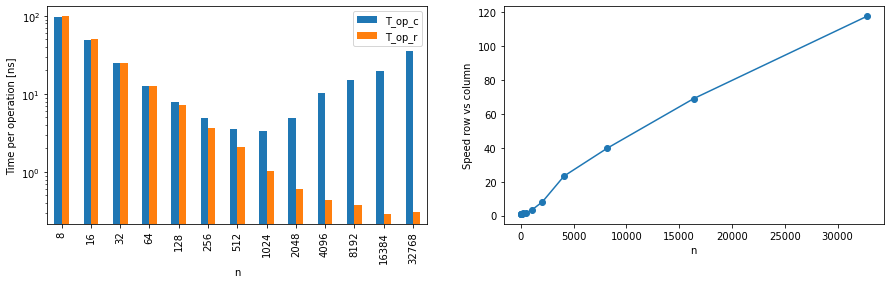

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
tc.loc[:, ['T_op_c', 'T_op_r']].plot(kind='bar', ax=ax[0], logy=True);
ax[0].set_ylabel('Time per operation [ns]');
tc.loc[:, 'T_op_c / T_op_r'].plot(marker='o', ax=ax[1]);
ax[1].set_ylabel('Speed row vs column');

- For small sizes, memory layout makes no difference
- For large sizes, row-wise operations *much* faster than column-wise
    - Absolute time per operation seems to level-off around 0.3ns
    - For a 2 GHz CPU, this time is *shorter than CPU clock cycle* (0.5 ns)
    - Possible because [AVX512](https://en.wikipedia.org/wiki/AVX-512) vector operations work on up to 8 doubles simultaneously
    
### Further steps

- Multiple repetitions of experiment to estimate statistical error of measurements
- Current `autorange()` use is inefficient, find more intelligent approach
- Also measure for Fortran memory layout
- Test array sizes that are not power of 2.

-------------

# Chutes & Ladders — Markov analysis

We will now use NumPy to analyse Chutes & Ladders not through simulation, but by modeling a stochastic process.

The game has two important properties:

- The movement of each player is completely independent of the
  movements of all other players as long as no player reaches
  field 90.
- Each move is completely determined by the current position of the figure and the cast of the die.

Therefore, each move does not depend on the past moves of the
figure in any other way than through the current position of the
figure. Because the future depends on the past only through the
present position of the figure, the movement of the figure is a
[Markov process](https://en.wikipedia.org/wiki/Markov_process). Markov
processes play an important role in modeling of a large range of
systems in biology, physics, economy etc.

An interesting question is how long games last, i.e., how many moves a
player has to make before reaching or passing field 90. The number of
moves will vary from game to game, and we are interested in the
probability distribution for the duration of the game. This is a
*first-passage-time problem*, an important class of problems first
studied by Erwin Schrödinger in 1915 (Zur Theorie der Fall- und
Steigversuche an Teilchen mit Brownscher Bewegung. *Physikalische
Zeitschrift* **16**:289–295, 1915).


### Background

The movement of the walker is a [Markov process](https://en.wikipedia.org/wiki/Markov_process), because the result of a single move depends only on the current position $j$ of the walker and the roll of the die. The entire history, i.e., *how* the walker got to position $j$ does not matter. Such processes are highly relevant in many branches of science and technology. One example of their use in neuroscience is in my PhD thesis ([Plesser, 1999](http://arken.umb.no/~plesser/publications/HEPlesser_PhD.pdf)). We can use techniques for Markov processes to study the movement of the walker in the Chutes & Ladders game.

Instead of obtaining the distribution of times to goal using simulation, we can also obtain it by numerical computation (or, using, e.g. SymPy, even exact). Let ${p^{(k)}}$ be a vector with elements $p^{(k)}_j$ ($0\leq j \leq G$) representing the probability probability that the walker is at position $j$ after move $k$. As initial conditions, we have
\begin{align}
p^{(0)}_0 &= 1\\
p^{(0)}_j &= 0\quad\mathrm{for}\; j>0
\end{align}
Let $M$ be a matrix that describes the how a single move changes the probabilities for the location of the walker. Specifically, let $M_{ij}$ be the probability that a walker in position $j$ will move to position $i$ in the next move. 
Let us first consider a game without chutes and ladders. The walker will then with equal probability move to one of the next six positions, except for the last few positions on the board, where any move will stop at $G$. We therefore have
\begin{align}
M_{0j} &= 0 \qquad\mathrm{(can\,never\,return\,to\,0)} \\
M_{ij} &= 1/6 \quad\mathrm{for}\; j+1\leq i \leq j+6 \;\mathrm{and}\; i < G\\
M_{Gj} &= 0 \quad\mathrm{for}\; j < G-6 \\
M_{Gj} &= 1 - (G-j-1)/6 \quad\mathrm{for}\; G-6 \leq j < G \\
M_{GG} &= 1\\
M_{ij} &= 0 \quad\mathrm{else}
\end{align}

We can then describe the motion of the walker across the board by the following equation:

\begin{equation}
p^{(k+1)} = M \times p^{(k)} \;.
\end{equation}

To obtain the probability distribution for the time to arrive at the goal $G$, we consider $p^{(k)}_G$, which corresponds to the probability that the walker has reached the goal after at most $k$ moves. If $G=6n$, then the goal can at the earliest be reached after $n$ moves (all sixes, probability $(1/6)^n$), and must at the latest be reached after $G$ moves ($G$ ones, probability $(1/6)^G$), i.e.,

\begin{align}
p^{(k)}_G &= 0 \quad\mathrm{for}\; k < n \\
p^{(n)}_G &= (1/6)^n \\
p^{(G)}_G &= 1
\end{align}

These cases provide test cases. Note that $Q_k=p^{(k)}_G$ is the *cumulative*  probability of arrival by step $k$. The probability for arriving *at* step $k$ is 
$$q_k = Q_k - Q_{k-1}\;.$$

Let us now assume that we have a ladder from $r$ to $s$ (chutes work the same way). Then the probability for the walker to move to $r$ will be $0$, and the corresponding probability will be "moved" to $s$. Specifically, based on matrix $M$ from above, we can defined matrix $L$ as follows:
\begin{align}
L_{rj} &= 0 \quad \forall j \qquad\mathrm{(no\,moves\,to\,r)}\\
L_{sj} &= M_{sj} + M_{rj}\quad \forall j \qquad\mathrm{(moves\,to\,s\,instead\,of\,r)}\\
L_{ij} &= M_{ij}\quad\mathrm{else}
\end{align}

### Implementation

We defined $p$ as an array with one column per time point we are interested in, and one row per position. We add some extra columns to ensure all is stationary after $G$ steps and to avoid confusion about which matrix dimension is what.

In [91]:
p = np.zeros((91, 100))
p[0, 0] = 1

In [92]:
M = np.zeros((91, 91))
M[90, 90] = 1
M[90, 84:90] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
for i in range(1, 90):
    M[i, max(0, i-6):i] = 1./6.

In [93]:
for k in range(1, 100):
    p[:, k] = M @ p[:, k-1]

In [94]:
plt.rcParams['savefig.dpi'] = 120          
plt.rcParams['figure.figsize'] = (12., 6.)

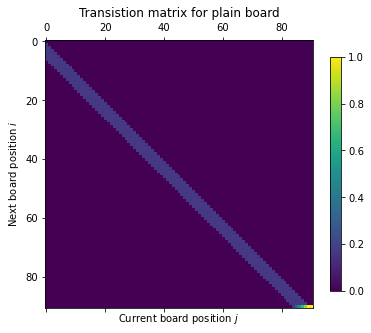

In [95]:
plt.matshow(M);
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Transistion matrix for plain board');
ax = plt.colorbar(shrink=0.7);

- The broad band slighly below the diagonal represents normal moves.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

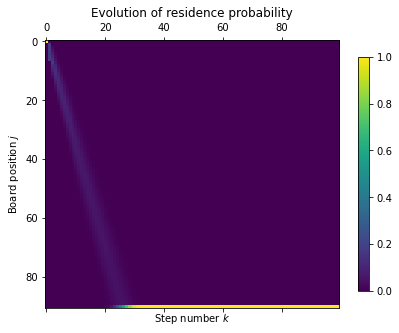

In [96]:
plt.matshow(p)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
ax = plt.colorbar(shrink=0.7);

#### Improving the figures

- Graphs are a bit difficult to read due to low contrast
- We define a function providing nice plotting
- For details, see the end of this part of the notebook

In [99]:
import matplotlib.cm as cm

def prettymat(m):
    cm7 = cm.get_cmap('YlGnBu_r', 7)
    cm7list = [cm7(i) for i in range(cm7.N)]
    cm7list[0] = [0.9, 0.9, 0.9]
    cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
    plt.matshow(m, cmap=cm7mod)
    cax = plt.colorbar(shrink=0.7);
    cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
    cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));
    plt.xlabel('Current board position $j$');
    plt.ylabel('Next board position $i$');
    plt.title('Transistion matrix for plain board');

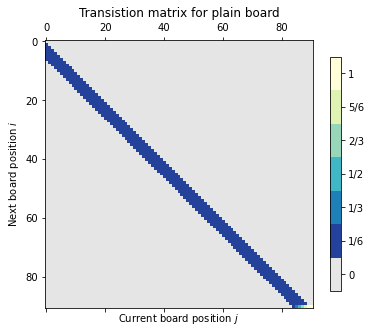

In [100]:
prettymat(M);

In [101]:
from matplotlib.colors import PowerNorm

def prettyprob(p):
    p_cutoff = 0.001
    cm_p = cm.get_cmap('YlGnBu_r')
    plt.matshow(p, cmap=cm_p,
                norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
    plt.xlabel('Step number $k$');
    plt.ylabel('Board position $j$');
    plt.title('Evolution of residence probability');
    cax = plt.colorbar(shrink=0.8, extend='min');
    cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 
                   0.1, 0.2, 0.5, 1.0]);

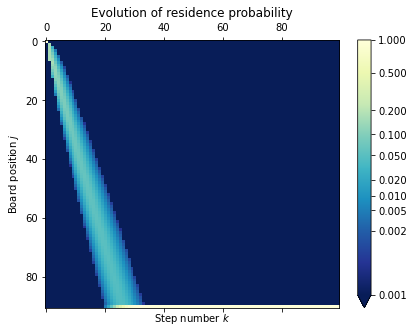

In [102]:
prettyprob(p)

#### Arrival time probabilities

In [103]:
Q = p[90, :]
q = np.zeros_like(Q)   # fiddle a little to avoid zero-indexing trouble
q[1:] = np.diff(Q)

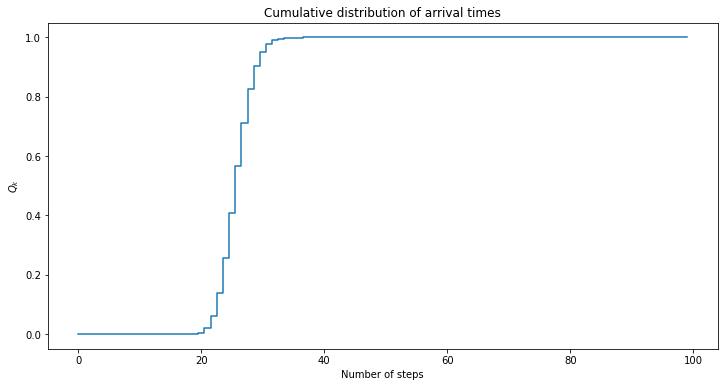

In [104]:
plt.step(range(100), Q, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$Q_k$');

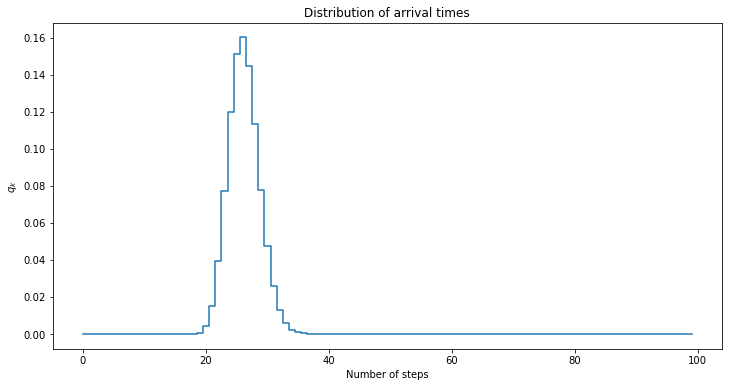

In [105]:
plt.step(range(100), q, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps');
plt.ylabel('$q_k$');

Let's check the border cases

In [106]:
Q[14], Q[15], (1./6.)**15, Q[15]-(1./6.)**15

(0.0, 2.126822490730477e-12, 2.126822490730477e-12, 0.0)

In [107]:
q[90]

0.0

In [108]:
Q[89]-1, Q[90]-1

(-1.3322676295501878e-15, -1.3322676295501878e-15)

In [109]:
(1./6.)**90

9.255235320869914e-71

Okay, probabilities for long game durations are far below numerical precision, therefore we do not see exact values in the tail of the distribution. But the error of $\mathcal{O}(10^{-15})$ is acceptable.

#### Matrix with chutes and ladders

We first define the standard set of chutes and ladders.

In [113]:
cnl = ( [(1, 40), (8, 10), (36, 52), (43, 62), (49, 79), (65, 82), (68, 85)] + 
        [(24, 5), (33, 3), (42, 30), (56, 37), (64, 27), (74, 12), (87, 70)] )

In [114]:
L = M.copy()
for start, dest in cnl:
    L[start, :] = 0.
    L[dest, :] += M[start, :]

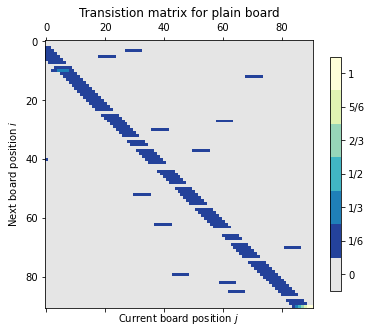

In [115]:
prettymat(L)

- The broad band slighly below the diagonal represents normal moves.
- Stripes above the diagonal represent chutes.
- Stripes below the broad band represent ladders.
- The bright blue bar in the top-left corner is the $8\to 10$ ladder which is so short it overlaps with normal movement.
- The $1	\to 40$ ladder is visible as a single bright blue pixel on row 40.
- Accumulation of probability in position $G=90$ is visible in the bottom right corner.

In [116]:
pL = np.zeros((91, 300))
pL[0, 0] = 1
for k in range(1, pL.shape[1]):
    pL[:, k] = L @ pL[:, k-1]

In [117]:
QL = pL[90]
qL = np.zeros_like(QL)
qL[1:] = np.diff(QL)

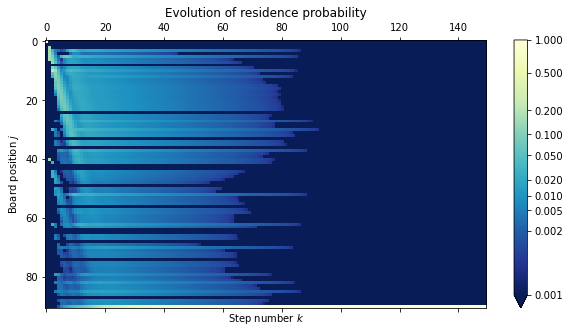

In [118]:
prettyprob(pL[:, :150])

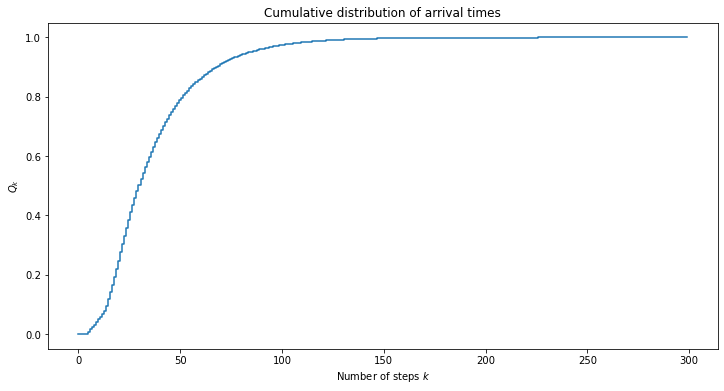

In [119]:
plt.step(range(len(QL)), QL, where='mid');
plt.title('Cumulative distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$Q_k$');

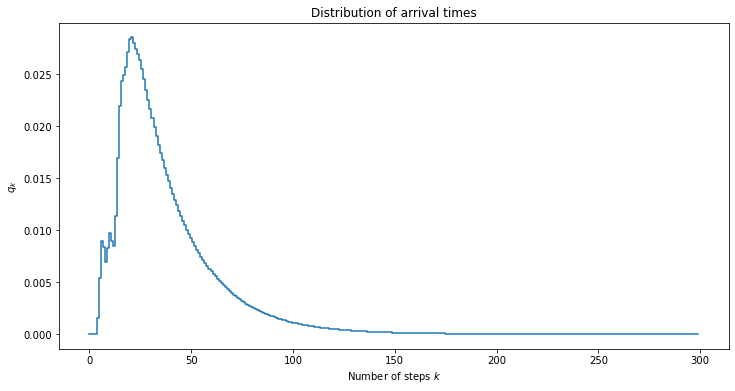

In [120]:
plt.step(range(len(qL)), qL, where='mid');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

We know that the shortest path is 4 steps, requiring a precise sequence of die casts, i.e., it has probability $6^{-4}$. We can check this:

In [121]:
print("No one should make it in three moves                   :", qL[3])
print("It is possible to make it in four moves                :", qL[4])
print("If there is a single way to do it four moves, we expect:", (1./6.)**4)
print("If there are two ways to do it in four moves, we expect:", 2 * (1./6.)**4)
print("Difference between results and two-ways expectation    :", qL[4] - 2 * (1./6.)**4)

No one should make it in three moves                   : 0.0
It is possible to make it in four moves                : 0.0015432098765432098
If there is a single way to do it four moves, we expect: 0.0007716049382716048
If there are two ways to do it in four moves, we expect: 0.0015432098765432096
Difference between results and two-ways expectation    : 2.168404344971009e-19


So apparently there are two ways to do it in four steps. Inspection of the board reveals the following possibilities:

1. Roll 1, then take ladder from 1 to 40.
1. Roll 3, then take ladder from 43 to 62.
1. Roll 6, then take ladder from 68 to 85.
1. From 85, you can reach 90 by either rolling 5 or 6.

Therefore, there are indeed exactly two ways of reaching the goal with four moves.

Furthermore, we can check that $Q_k	\to 1$ for $k	\to\infty$:

In [122]:
1 - QL[-1]

5.445159400263577e-06

This indicates convergence to $1$, but at the same time a rather long tail. We can plot semilogarithmically to see the tail better:

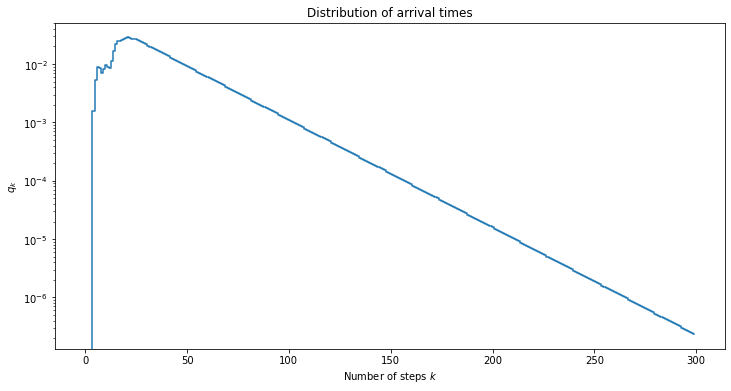

In [123]:
plt.step(range(len(qL)), qL, where='mid');
plt.yscale('log')
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');

The tail of the distribution is linear in the semilogarithmic plot, indicating that it follows an exponential distribution. For more detailed characterization, we could fit the distribution for $k>50$ to an exponential distribution; we leave this as an exercise.

#### Comparison with simulation

In [124]:
from chutes import multi_game_experiment

In [125]:
d = multi_game_experiment(num_games=20000, num_players=1, seed=1234567)

In [126]:
qE = np.zeros(max(d)+1, dtype=float)
for n in frozenset(d):
    qE[n] = d.count(n)
qE /= len(d)

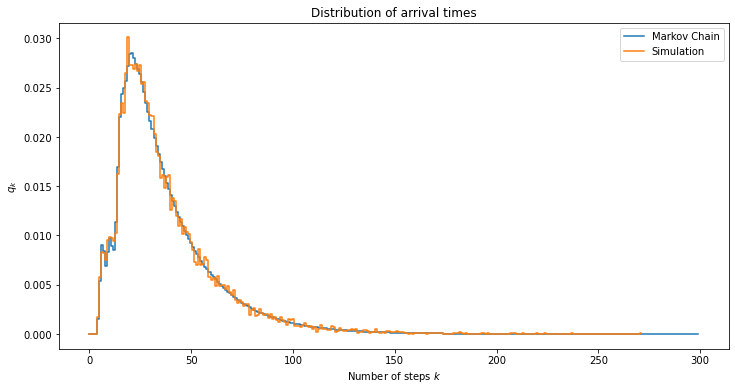

In [127]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$');
plt.legend();

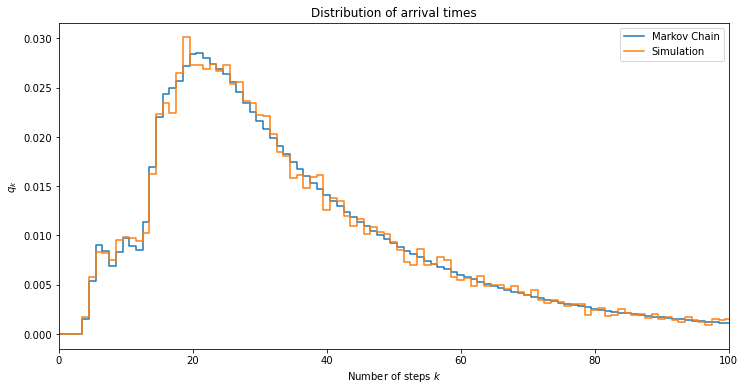

In [128]:
plt.step(range(len(qL)), qL, where='mid', label='Markov Chain');
plt.step(range(len(qE)), qE, where='mid', label='Simulation');
plt.title('Distribution of arrival times')
plt.xlabel('Number of steps $k$');
plt.ylabel('$q_k$')
plt.xlim(0, 100)
plt.legend();

Markov chain analysis and simulation are apparently in good agreement. This qualitative statement based on visual inspection (which may be misleading) should be substantiated by a proper statistical test, cf *Extensions* below.

#### Games with multiple players

In order to find the distribution of the arrival time for the first of $N$ (identical) players in a game, we can use results from [order statistics](http://en.wikipedia.org/wiki/Order_statistic). If $T_n$ is the random variable representing the arrival time of walker $n$, then we are interested in the distribution of $\min \{T_1, T_2, ..., T_N\}$, where all $T_n$ are independently and identically distributed according to the discrete distribution $q_k$. From [David and Nagaraja (1992, Eq 2.1.3)](http://books.google.no/books?id=bdhzFXg6xFkC&dq=Arnold,+B.+C.,+N.+Balakrishnan,+H.+N.+Nagaraja.+1992.+A+First+Course+in+Order+Statistics.+Wiley,+New+York.&hl=no&source=gbs_navlinks_s), we obtain the cumulative distribution of the minimum of $N$ random variables i.i.d. with cumulative distribution $Q_k$ as
$$R^{(N)}_k = 1 - ( 1 - Q_k )^N$$
and the corresponding distribution as
$$r^{(N)}_k = R^{(N)}_k - R^{(N)}_{k-1}\;.$$
See also [Evans et al (2006)](http://www.math.wm.edu/~leemis/2006informsjoc.pdf).

We consider a game with four players.

In [129]:
N = 4
RL = 1 - (1 - QL)**N
rL = np.zeros_like(RL)   # fiddle a little to avoid zero-indexing trouble
rL[1:] = np.diff(RL)

In [130]:
dN = multi_game_experiment(num_games=20000, num_players=4, seed=1234567)
rE = np.zeros(max(dN)+1, dtype=float)
for n in frozenset(dN):
    rE[n] = dN.count(n)
rE /= len(dN)

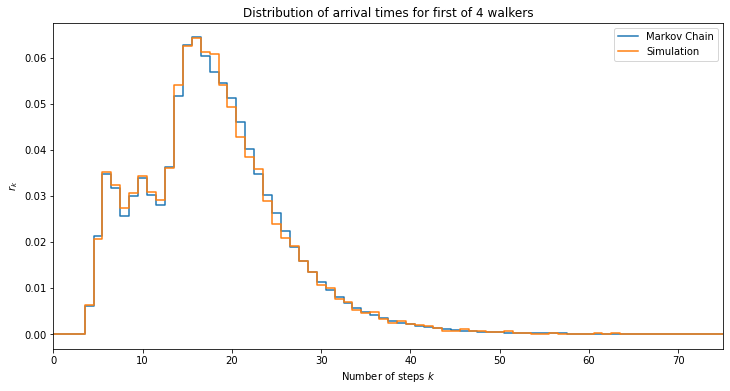

In [131]:
plt.step(range(len(rL)), rL, where='mid', label='Markov Chain');
plt.step(range(len(rE)), rE, where='mid', label='Simulation');
plt.title('Distribution of arrival times for first of {:d} walkers'.format(N))
plt.xlabel('Number of steps $k$');
plt.ylabel('$r_k$');
plt.legend();
plt.xlim(0, 75);

Also in this case theory and simulation appear to agree very well; see *Extensions* below for a note on statistical tests for distributions. As a sanity check, we check that no-one arrived in fewer than four moves, and that $R_k^{(4)}	\to1$ for $k	\to\infty$:

In [132]:
print(RL[3], RL[4])
print(1 - RL[-1])

0.0 0.006158565220760082
0.0


### Extensions

#### Statistical tests for distributions
Above, we compared distributions obtained numerically by Markov chain analysis with distributions obtained from simulations by visual inspection. While this is a useful first step (*always* look at your data before applying statistical analysis!), it may also be misleading. To draw solid conclusions, we need to apply statistical tests to check whether the simulation results follow the distribution obtained from Markov chain analysis.

For continuous random variables, e.g., variables following a Gaussian or exponential distribution, the proper test is the [Kolmogorov-Smirnov test](http://itl.nist.gov/div898/handbook/eda/section3/eda35g.htm), which is available as [`scipy.stats.kstest`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html).

The distribution of game durations, though, is a discrete distribution and we need to apply the [$\chi^2$-test](http://itl.nist.gov/div898/handbook/eda/section3/eda35f.htm), which is available as [`scipy.stats.chisquare`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html). In this test, we compare the number of times each game duration has been observed with the number predicted, $n_k=q_k\times N$, where $N$ is then number of games played. To be valid, the $\chi^2$-test requires that $n_k >5\; \forall k$. In order to ensure that this is fulfilled, we proceed as follows:

1. Find $k_{\mathrm{max}}$, the game duration for with highest probability $q_k$. The distribution for $k>k_{\mathrm{max}}$ is essentially the tail of the distribution, while the part $k<k_{\mathrm{max}}$ is the interesting part.
1. Find $k_{\mathrm{min}} < k_{\mathrm{max}}$, the game duration for which $q_k$ is smallest (but non-zero), to the left of the maximum.
1. Choose $N$ so that $N\times q_{k_{\mathrm{min}}}>5$.
1. Find $k_{\mathrm{tail}}$ as the largest $k$ for which both of the following conditions are fulfilled:

    1. $N\times q_k>5$
    1. $(1-Q_k)\times N>5$

   Condition A. ensures that the expectation for the rightmost bin, $k_{\mathrm{tail}}$ is more than 5, while B. ensures that the remaining tail, which we will collapse into a single bin, also has an expectation of at least 5.
1. Simulate $N$ games.
1. Each game duration $k$ forms one *bin* for the $\chi^2$-test, except that all game durations $k>k_{\mathrm{tail}}$ are combined in a single bin. The expectation for this bin is $n_{\mathrm{tail}}=(1-Q_{k_\mathrm{tail}})\times N$.
1. Apply the $\chi^2$-test to the data.

#### Modeling players with internal state
In order to treat players with internal state, such as resilient players (take extra step(s) after sliding down) or lazy players (take fewer step(s) after climbing up), we need to split every element of vector $p$ into two: one representing the probability of being in normal, and on of being in special mode at a given location. Matrices $M$ and $L$ then have twice as many rows and columns and become more complicated, although the design approach is the same.

#### Using sparse matrices
For very large matrices, it may be useful to consider *sparse matrix* implementations from SciPy, which do not store all the zeros elements in $M$ and $L$.

### Using more suitable color maps

- The color maps we used above were not optimal due to limited contrast
- We will look at better color maps here
- We first define functions to
    - create a propagator matrix M for a given game board
    - evolve the state of the game over time
    - extract the arrival-time distribution

In [57]:
def propagator(ladders=None, chutes=None, goal=90):
    ladders = ladders if ladders is not None else [(1, 40), (8, 10), (36, 52), 
                                                   (43, 62), (49, 79), (65, 82), 
                                                   (68, 85)] 
    chutes = chutes if chutes is not None else [(24, 5), (33, 3), (42, 30), 
                                                (56, 37), (64, 27), (74, 12), 
                                                (87, 70)]
    
    M = np.zeros((goal+1, goal+1))
    M[goal, goal] = 1
    M[goal, (goal-6):goal] = np.array([1., 2., 3., 4., 5., 6.]) / 6.
    for i in range(1, goal):
        M[i, max(0, i-6):i] = 1./6.
        
    L = M.copy()
    for start, dest in chutes + ladders:
        L[start, :] = 0.
        L[dest, :] += M[start, :]
        
    return L

In [58]:
def evolve(prop, num_moves, initial=None):
    r, c = prop.shape
    assert r == c, "Propagator must be square"
    if initial is None:
        initial = np.zeros(r)
        initial[0] = 1
    else:
        assert len(initial) == r, "Initial size wrong"
    
    p = np.zeros((r, num_moves+1))
    p[:, 0] = initial
    
    for k in range(1, num_moves+1):
        p[:, k] = np.dot(prop, p[:, k-1])
        
    return p    

In [59]:
def arrival_dist(p_evol):
    Q = p_evol[-1, :]
    q = np.zeros_like(Q)
    q[1:] = np.diff(Q)
    return q, Q

#### Propagator matrix—standard color map

In [60]:
prop90 = propagator()

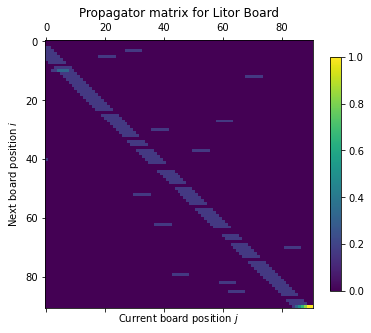

In [61]:
plt.matshow(prop90)
plt.xlabel('Current board position $j$');
plt.ylabel('Next board position $i$');
plt.title('Propagator matrix for Litor Board');
plt.colorbar(shrink=0.7);

- Problems with the figure above: 
    - all values in the matrix are either 0 or a multiple of 1/6
    - this is not clear from the color scale
    - actual values are difficult to read off
    - color scale is not linear in any sense
- Solution: Alternative color map
    - See [Choosing colormaps](http://matplotlib.org/users/colormaps.html) and [Colormaps reference](http://matplotlib.org/examples/color/colormaps_reference.html)
    - See also [this presentation on the default colormap in Matplotlib 2.0](https://bids.github.io/colormap/)
- Some of the examples below are based on ideas from
    - http://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
    - http://pyhogs.github.io/colormap-examples.html

##### Step 1: Use a perceptually uniform color map

- Lightness changes uniformly over range of color map
- The `_r` suffix on the name reverses the color map, so that 0 is darkest
- For clarity, we use a small matrix and drop axis decorations

In [62]:
import matplotlib.cm as cm

In [64]:
propsmall = propagator(ladders=[(3, 5), (10, 15)], 
                       chutes=[(7, 2), (16, 12)], goal=20)

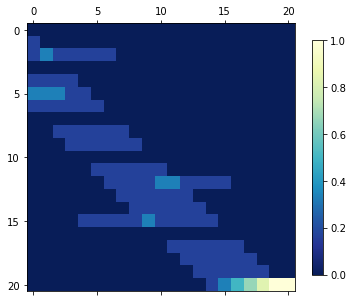

In [65]:
plt.matshow(propsmall, cmap=cm.YlGnBu_r)
plt.colorbar(shrink=0.7);

##### Step 2: Discrete color map with values 0, 1/6, 2/6, ..., 1

- Seven different colors needed
- We can just get a color map with the necessary number of levels

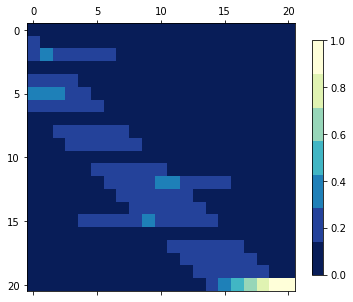

In [66]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
plt.colorbar(shrink=0.7);

- The axis label are now not very helpful
- We can change the placement of the labels

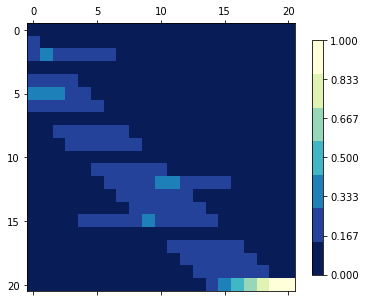

In [67]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.linspace(0, 1, 7));

- Better, but it would be even nicer to place the markers in the center of the boxes and show fractions
- For $n$ boxes, the box centers are placed at

$$y_k = \frac{1}{2n} + \frac{k}{n} \quad k = 0, 1, \dots, n-1$$

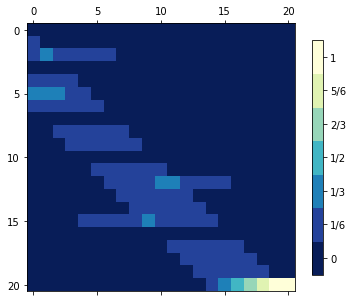

In [68]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
plt.matshow(propsmall, cmap=cm7)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

##### Step 3: change representation of zero probability for better contrast

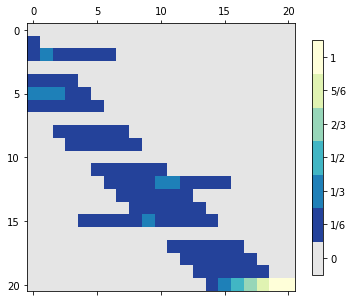

In [69]:
cm7 = cm.get_cmap('YlGnBu_r', 7)
cm7list = [cm7(i) for i in range(cm7.N)]
cm7list[0] = [0.9, 0.9, 0.9]
cm7mod = cm7.from_list('mymap', cm7list, cm7.N)
plt.matshow(propsmall, cmap=cm7mod)
cax = plt.colorbar(shrink=0.7);
cax.set_ticks(np.arange(0., 7.) / 7. + 1./14.);
cax.set_ticklabels(('0', '1/6', '1/3', '1/2', '2/3', '5/6', '1'));

#### Time evolution of residence probability

- We will use a similar color map as above for the time evolution, but with full resolution
- We will mark values below a certain limit with a separat color

In [70]:
p90 = evolve(prop90, 200)

In [71]:
import copy

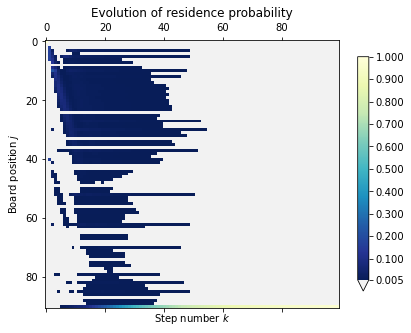

In [73]:
p_cutoff = 0.005

cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p, vmin=p_cutoff)
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.7, extend='min');
cax.set_ticks([p_cutoff] + list(np.arange(0.1, 1.01, 0.1)));

##### Step 4: Zooming in on parts of the color scale

- We can use different normalizations for the color scale to make important parts of the figure more visible
- Here, we use a power norm $x^\gamma$

In [74]:
from matplotlib.colors import PowerNorm

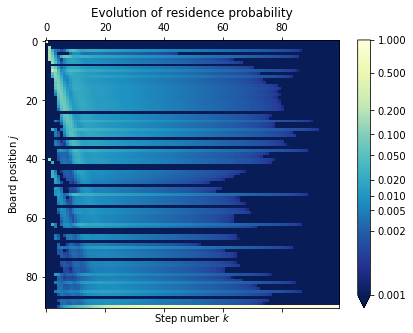

In [77]:
p_cutoff = 0.001
cm_p = copy.copy(cm.get_cmap('YlGnBu_r'))
cm_p.set_under((0.95, 0.95, 0.95))
plt.matshow(p90[:, :100], cmap=cm_p,
            norm=PowerNorm(gamma=0.2, vmin=p_cutoff, vmax=1))
plt.xlabel('Step number $k$');
plt.ylabel('Board position $j$');
plt.title('Evolution of residence probability');
cax = plt.colorbar(shrink=0.8, extend='min');
cax.set_ticks([p_cutoff, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]);

--------

# Block project

## Practical information

### January block

- Starts Monday 3 January 09.15 in Festsalen, Samfunnet
- Mandatory attendance 09.15–15.00 until Tuesday 18 January
    - Contact Plesser without delay if you cannot come to class because of illness or other important reason!
- Presentation preparation 19–21 January
- Exam 24/25 January
- Currently still planning for on-site course
    - Keep an eye on e-mail/Canvas notifications!
    
### June block

- Check-in via e-mail/Canvas form in May 2022
- Starts Monday 30 May 09.15
- Mandatory attendance 09.15–15.00 until Wednesday 15 June
- Presentation preparation 16–17 June
- Exam 20/21 June

### How to maintain and improve your Python skills

- Look for programming opportunities in other courses or real life!
- If you do it with Excel, could you do it in Python?
- Nicolas P. Rougier, *100 numpy exercises*, https://github.com/rougier/numpy-100/blob/master/100_Numpy_exercises.ipynb"
- Have a look at https://www.checkio.org
    

## Project preview

- Review of final exercise (separate notebook)
- Sneak preview